In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from config import opt
import models
import joblib
import torch
from tqdm import tqdm
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['font.serif'] = ['KaiTi']
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
DAY_POINTS = 48

In [3]:
test_data = pd.read_csv('./raw_data/test_data.csv')

In [4]:
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.set_index('date')

In [5]:
data_utility = joblib.load('./data_utility.pkl')

In [6]:
feature_columns = data_utility.get_feature_columns()
feature_index = data_utility.get_feature_index()

In [7]:
model = models.DTCN(feature_columns=feature_columns,feature_index=feature_index,
                    dnn_hidden_units=opt.dnn_hidden_units,window_size=opt.WINDOW_SIZE,
                    output_size=opt.out_size,residual_size=opt.residual_size,
                    skip_size=opt.skip_size,dilation_cycles=opt.dilation_cycles,
                    dilation_depth=opt.dilation_depth)

In [9]:
model.load('./models/checkpoints/DTCN2_P12.pth')

In [10]:
def val(model,data_utility,test_X,test_Y):
    model.eval()
    
    total_loss = 0
    total_pred_loss = 0
    
    for i,(data,label) in tqdm(enumerate(data_utility.get_batches(test_X,test_Y,opt.batch_size))):
        inputs = data
        targets = label
        
        preds = model(inputs)
        preds = preds.squeeze(2)
        
        loss = torch.mean(torch.pow(targets-preds,2))
        total_loss += loss
        
        true_label = targets[:,-DAY_POINTS:]
        pred_label = preds[:,-DAY_POINTS:]
        
        pred_loss = torch.mean(torch.pow(targets[:,-48:]-preds[:,-48:],2))
        total_pred_loss += pred_loss
    
    model.train()
    
    return total_loss/(i+1),total_pred_loss/(i+1)

In [11]:
def load_test_X_Y(data,data_utility):
    data = data.copy()
#     data.drop(columns=['date'],inplace=True)
    
    scaler = data_utility.get_scaler()
    lbes = data_utility.get_lbes()
    
    data[opt.dense_features] = scaler.transform(data[opt.dense_features])
    for feat in opt.sparse_features:
        data[feat] = lbes[feat].transform(data[feat])
    y_data = data[opt.target].values
    
    data = data_utility.build_dataset(data)
    X,Y = data_utility.build_X_Y(data,y_data,opt.P,opt.WINDOW_SIZE)
    return X,Y

In [11]:
test_X,test_Y = load_test_X_Y(test_data,data_utility)

In [187]:
loss,pred_loss = val(model,data_utility,test_X,test_Y)

221it [00:06, 36.22it/s]


In [188]:
loss

tensor(0.0544, grad_fn=<DivBackward0>)

In [189]:
pred_loss

tensor(0.0529, grad_fn=<DivBackward0>)

预测

In [35]:
def predict(data,history_time,pred_time,data_utility,opt,model):
    history_data = test_data[history_time:pred_time].copy()
    history_data.reset_index(inplace=True,drop=True)
    true_label = test_data[pred_time:pred_time]['Power'].values
    
    scaler = data_utility.get_scaler()
    lbes = data_utility.get_lbes()
    history_data[opt.dense_features] = scaler.transform(history_data[opt.dense_features])
    for feat in opt.sparse_features:
        history_data[feat] = lbes[feat].transform(history_data[feat])
    history_data = data_utility.build_dataset(history_data)
    
    pred_label = torch.zeros(DAY_POINTS)
    model.eval()
    with torch.no_grad():
        for i in range(int(DAY_POINTS/opt.P)):
            inputs = torch.from_numpy(history_data[i*opt.P:opt.WINDOW_SIZE+i*opt.P]).unsqueeze(0)
            inputs = inputs.type(torch.FloatTensor)
            pred = model(inputs)
            pred_label[i*opt.P:(i+1)*opt.P] = pred[0,-opt.P:,0]
#             if(i!=int(DAY_POINTS/opt.P)-1):
#                 history_data[opt.WINDOW_SIZE+i*opt.P:opt.WINDOW_SIZE+(i+1)*opt.P,-1]=pred[0,-opt.P:,0]
    
    pred_label = pred_label.numpy()
    preds = np.zeros([48,5])
    preds[:,-1] = pred_label
    pred_label = scaler.inverse_transform(preds)[:,-1]
    mape = (np.abs(pred_label-true_label)/true_label).mean()*100
    print(mape)
    
    plt.title("下一时刻预测负荷图")
    plt.plot(true_label,c='r',label='true')
    plt.plot(pred_label,c='b',label='pred')
    plt.legend(loc='best')
    plt.show()

In [36]:
history_time = '2010-12-13'
pred_time = '2010-12-16'

3.7883110749409035


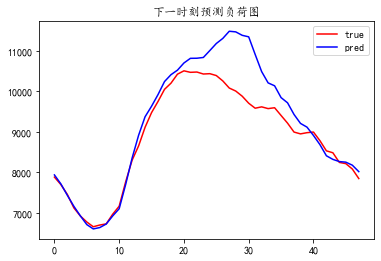

In [37]:
predict(test_data,history_time,pred_time,data_utility,opt,model)